# Đề Tài: tối ưu bài toán Seam Carving bằng phương pháp song song hoá

# Thông tin nhóm
- Trần Công Quang, MSSV: 20280078
- Nguyễn Minh Hoàng, MSSV: 20280036
- Giảng viên: Phạm Trọng Nghĩa


# Giới thiệu đề tài
- **Seam Carving** là một kỹ thuật trong xử lý ảnh cho phép thay đổi kích thước của ảnh một cách nhạy cảm với nội dung, được lần đầu giới thiệu trong bài báo cáo khoa học của S. Avidan & A. Shamir. Trong bài báo, việc thay đổi kích thước ảnh được thực hiện bằng cách loại bỏ đi các điểm ảnh ít quan trọng và giữ lại các điểm ảnh quan trọng. Phương pháp này tìm ra và xóa bỏ (hoặc thêm vào) các "đường nối" (seams) - những đường đi qua ảnh chứa các điểm ảnh có mức năng lượng (energy) thấp, sao cho ảnh sau khi thay đổi kích thước vẫn giữ được các đặc điểm quan trọng.
- **Mục tiêu của nhóm** là triển khai lại thuật toán theo hướng tuần tự trên CPU theo cách tối ưu nhất về mặt chi phí tính toán sử dụng ngôn ngữ C, sau đó phân tách bài toán để sử dụng tối ưu khả năng thực thi song song của GPU và tốc độ xử lý tuần tự vượt trội của CPU bằng extension CUDA trên C/C++



# Nội dung chương trình
## Xử lý ảnh
(trong quá trình mô tả, ta quy ước ảnh đầu vào có kích thước width x height)

 Do giới hạn về mặt thời gian và kiến thức, nhóm quyết định chỉ xử lý ảnh đầu vào và ảnh kết quả trên định dạng JPG, dữ liệu ảnh trong quá trình tính toán là ảnh màu RGB được lưu trên cấu trúc array của C, với một pixel là 3 phần tử liên tiếp trên ảnh RGB (số cột về mặt giá trị trong ma trận này là `[width x 3] x height`), với một ảnh 2 chiều gồm nhiều pixel được lưu dạng row-major trên ma trận một chiều.

## Thuật toán Seam Carving
### Cài đặt tuần tự
 - Tính toán ma trận năng lượng (Energy): sử dụng công thức `gray = 0.299 * red + 0.587 * green + 0.114 * blue` tính dạng ảnh đen trắng (gray image) từ ảnh RGB, sau đó dùng ảnh đen trắng này để tính toán mức độ thay đổi tương quan giữa các điểm ảnh bằng cách đưa ảnh qua 2 lớp filter `Sobel_X` và `Sobel_Y` (3x3)
<center><img src="./images-for-report/sobel.jpg" width="400" height="200"></center>

- Tính toán đường đi từ mỗi điểm ảnh trong hàng đầu tiên của ảnh để đi đến điểm ảnh trong hàng cuối cùng của ảnh: ta sử dụng 2 ma trận để hỗ trợ cho quá trình này:
  - energyMap: hàng cuối cùng là giá trị hàng cuối cùng của ma trận năng lượng, sau đó ta thực hiện vòng lặp từ hàng thứ 2 từ dưới lên, điểm ảnh từ trái qua phải như sau, giá trị điểm ảnh là   `energy[i,j] + min(energyMap[i-1, j-1], energyMap[i-1, j], energyMap[i-1, j+1])`
  - nextElements: truy dấu chiều đi của điểm hiện tại đi tới điểm tiếp theo trong quá trình tính toán giá trị của energyMap
- Tìm đường viền có tổng giá trị energy nhỏ nhất: là đường xuất phát từ cột có giá trị nhỏ nhất trong hànd đầu tiên của energyMap, các cạnh tiếp theo của đường viền được xác định thông qua ma trận đường đi nextElements
- Xoá đường viền trên ảnh RGB và ma trận năng lượng

Ta lặp lại quá trình: tính energyMap, nextElements, tìm seam nhỏ nhất và xoá seam này đến khi có được ảnh có kích thước mong muốn
## Cài đặt song song V1
được cài đặt tương tự như tuần tự nhưng thêm một số cơ chế song song giúp tăng tốc độ tính toán. Cụ thể một số điểm đáng chú ý ở mỗi hàm là
  - hàm grayScaleImageDeviceV1 : mỗi thread tính gray scale value cho một pixel
  - hàm findEnergyDeviceV1 : tích hợp hàm tính filter ở lab cũ trong môn học để tính đồng thời cả 2 filter và căn tổng bình phương của 2 ma trận này, trong đó nổi trội là có sử dụng đến CMEM để lưu filter và SMEM để lưu để lưu giá trị của ảnh trong quá trình tính filter
  - hàm findEnergyMapDeviceV1: được cấu hình kernal gridsize(1), blocksize(1024), tận dụng khả năng synch giữa các thread trong block để song song các cột trong hình ảnh
  - hàm findSeamDeviceV1: tính bằng 1 thread duy nhất như một cách tuần tự do bài toán này rất khó để chuyển sang sang song mà kết quả là không quá đáng kể
  - hàm removeSeamDeviceV1: thực hiện song song một cách đơn giản
  
ngoài ra ở mỗi hàm kernal chúng em cũng đã chú ý:

  - Truy cập vùng nhớ một cách liên tiếp nhau giúp đạt tính coalescent
  - Hạn chế copy các vùng nhớ không cần thiết từ GMEM sang SMEM
  - Lưu trữ dữ liệu bằng các kiểu dữ liệu với kích thước tối thiểu để giảm chi phí di chuyển vùng nhớ không cần thiết (EX: lưu giá trị điểm ảnh dạng uint_8)

## Cài đặt song song V2
- Thuật toán Seam Carving V2: dùng lại phần lớn các hàm song song từ version 1 với một số thay đổi chỉnh sau
    - gộp hàm tính grayscale và tính energyMap nhằm giảm chi phí



# Cấu trúc project Folder
 - **/main.cu**: Tệp chính thực hiện đọc đầu vào, thực thi quá trình biến đổi ảnh và đo lường hiệu suất.

 - **/images**: Thư mục chứa các ảnh mẫu để xử lý.

 - **/include/**: Thư mục chứa các tệp tiêu đề.
  - **seam_carving.h**: Định nghĩa hàm và cấu trúc cho thuật toán seam carving.
  - **utility.h**: Cung cấp hàm tiện ích, đọc/ghi ảnh, và đo lường hiệu suất.

 - **/src/**: Thư mục chứa mã nguồn thực thi.
   - **seam_carving.cu**: Chứa định nghĩa hàm seam carving.
   - **utility.cu**: Chứa định nghĩa hàm tiện ích.


# Demo

In [1]:
from IPython.display import Image, display
from PIL import Image as PILImage
import os

def display_images(*image_paths):
    for image_path in image_paths:
        if os.path.isfile(image_path):
            # Get image size
            size = os.path.getsize(image_path)

            # Open the image using PIL to get its width and height
            with PILImage.open(image_path) as img:
                width, height = img.size

            # Display the image in its original size
            display(Image(filename=image_path))

            # Print the width and height
            print(f"Image Size: {width}x{height} pixels")
        else:
            print(f"Image not found: {image_path}")

In [2]:
! # run this if clone in first time -------------------
!git clone https://github.com/qangTran/tpm.git
%cd ./tpm/code
! # run this if clone in second time -----------------
# %cd ../..
# !rm -r tpm
# !git clone https://github.com/qangTran/tpm.git
# %cd ./tpm/code

/
rm: cannot remove 'tpm': No such file or directory
Cloning into 'tpm'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 126 (delta 42), reused 119 (delta 35), pack-reused 0
Receiving objects: 100% (126/126), 1.84 MiB | 19.43 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/tpm/code


In [3]:
# compile program
!nvcc main.cu src/utility.cu src/seam_carving.cu -Iinclude -ljpeg
# !nvcc -g -G -I /usr/local/cuda/samples/common/inc/ -L/usr/local/cuda/include -lcublas -lcusolver main.cu src/utility.cu src/seam_carving.cu -Iinclude -ljpeg
# !compute-sanitizer ./a.out


__________ GPU Device Information __________
| Name:                          Tesla T4
| Compute Capability:            7.5
| Num SMs:                       40
| Max Threads per SM:            1024
| Max Warps per SM:              32
| Global Memory (GMEM):          15835660288 bytes
| Shared Memory per SM:          65536 bytes
| Shared Memory per Block:       49152 bytes
|____________________________________________
Image size: 310x210
Resized image size: 200x210

Seam Carving by host
Time: 176.563 ms

Seam Carving by device V1
Time: 49.897 ms
Error Distance: 0.162

Seam Carving by device V2
Time: 49.366 ms
Error Distance: 0.162


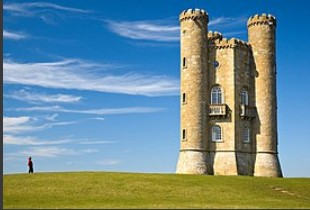

Image Size: 310x210 pixels


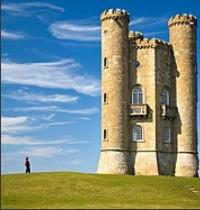

Image Size: 200x210 pixels


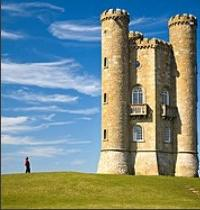

Image Size: 200x210 pixels


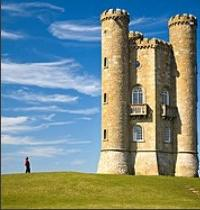

Image Size: 200x210 pixels


In [13]:
!./a.out -i images/tower.jpg -nw 200 -bz 32
display_images("images/tower.jpg", "resizedImageUsingHost.jpg", "resizedImageUsingDeviceV1.jpg", "resizedImageUsingDeviceV2.jpg")

__________ GPU Device Information __________
| Name:                          Tesla T4
| Compute Capability:            7.5
| Num SMs:                       40
| Max Threads per SM:            1024
| Max Warps per SM:              32
| Global Memory (GMEM):          15835660288 bytes
| Shared Memory per SM:          65536 bytes
| Shared Memory per Block:       49152 bytes
|____________________________________________
Image size: 620x417
Resized image size: 500x417

Seam Carving by host
Time: 844.902 ms

Seam Carving by device V1
Time: 112.576 ms
Error Distance: 0.820

Seam Carving by device V2
Time: 112.058 ms
Error Distance: 0.820


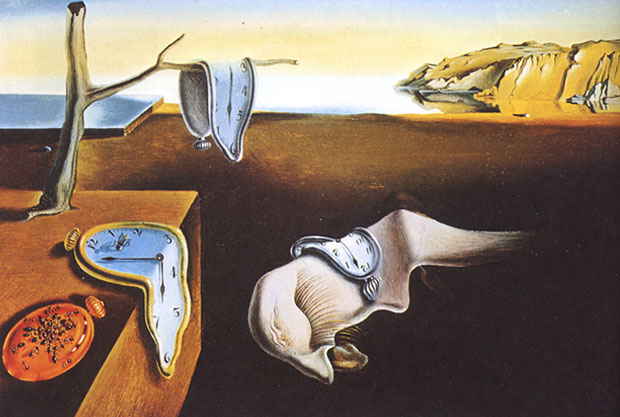

Image Size: 620x417 pixels


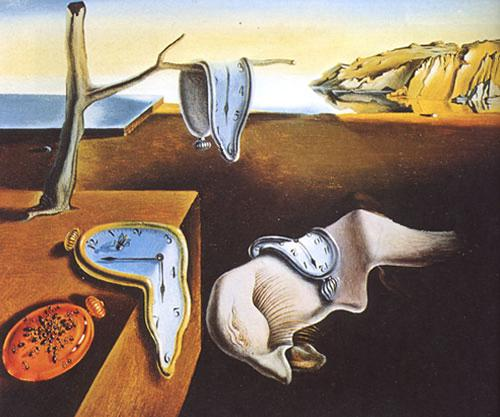

Image Size: 500x417 pixels


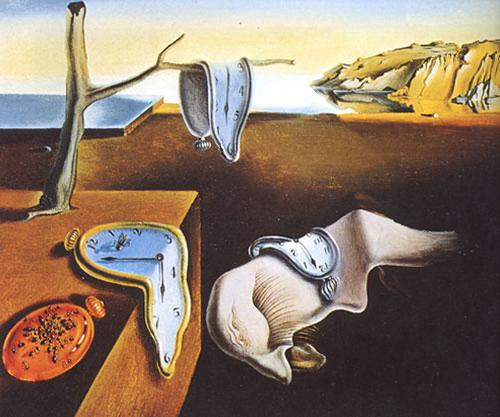

Image Size: 500x417 pixels


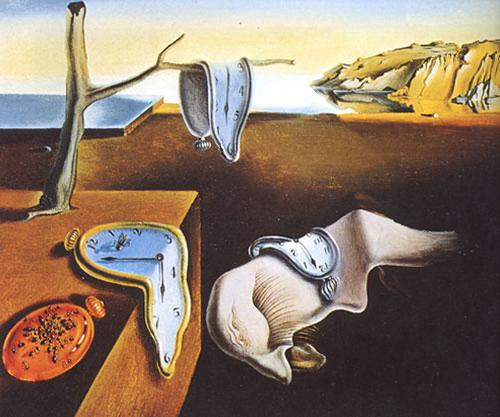

Image Size: 500x417 pixels


In [11]:
!./a.out -i images/clock.jpg -nw 500 -bz 32
display_images("images/clock.jpg", "resizedImageUsingHost.jpg", "resizedImageUsingDeviceV1.jpg", "resizedImageUsingDeviceV2.jpg")

__________ GPU Device Information __________
| Name:                          Tesla T4
| Compute Capability:            7.5
| Num SMs:                       40
| Max Threads per SM:            1024
| Max Warps per SM:              32
| Global Memory (GMEM):          15835660288 bytes
| Shared Memory per SM:          65536 bytes
| Shared Memory per Block:       49152 bytes
|____________________________________________
Image size: 1536x1024
Resized image size: 1000x1024

Seam Carving by host
Time: 21721.801 ms

Seam Carving by device V1
Time: 1272.879 ms
Error Distance: 2.056

Seam Carving by device V2
Time: 1124.856 ms
Error Distance: 2.056


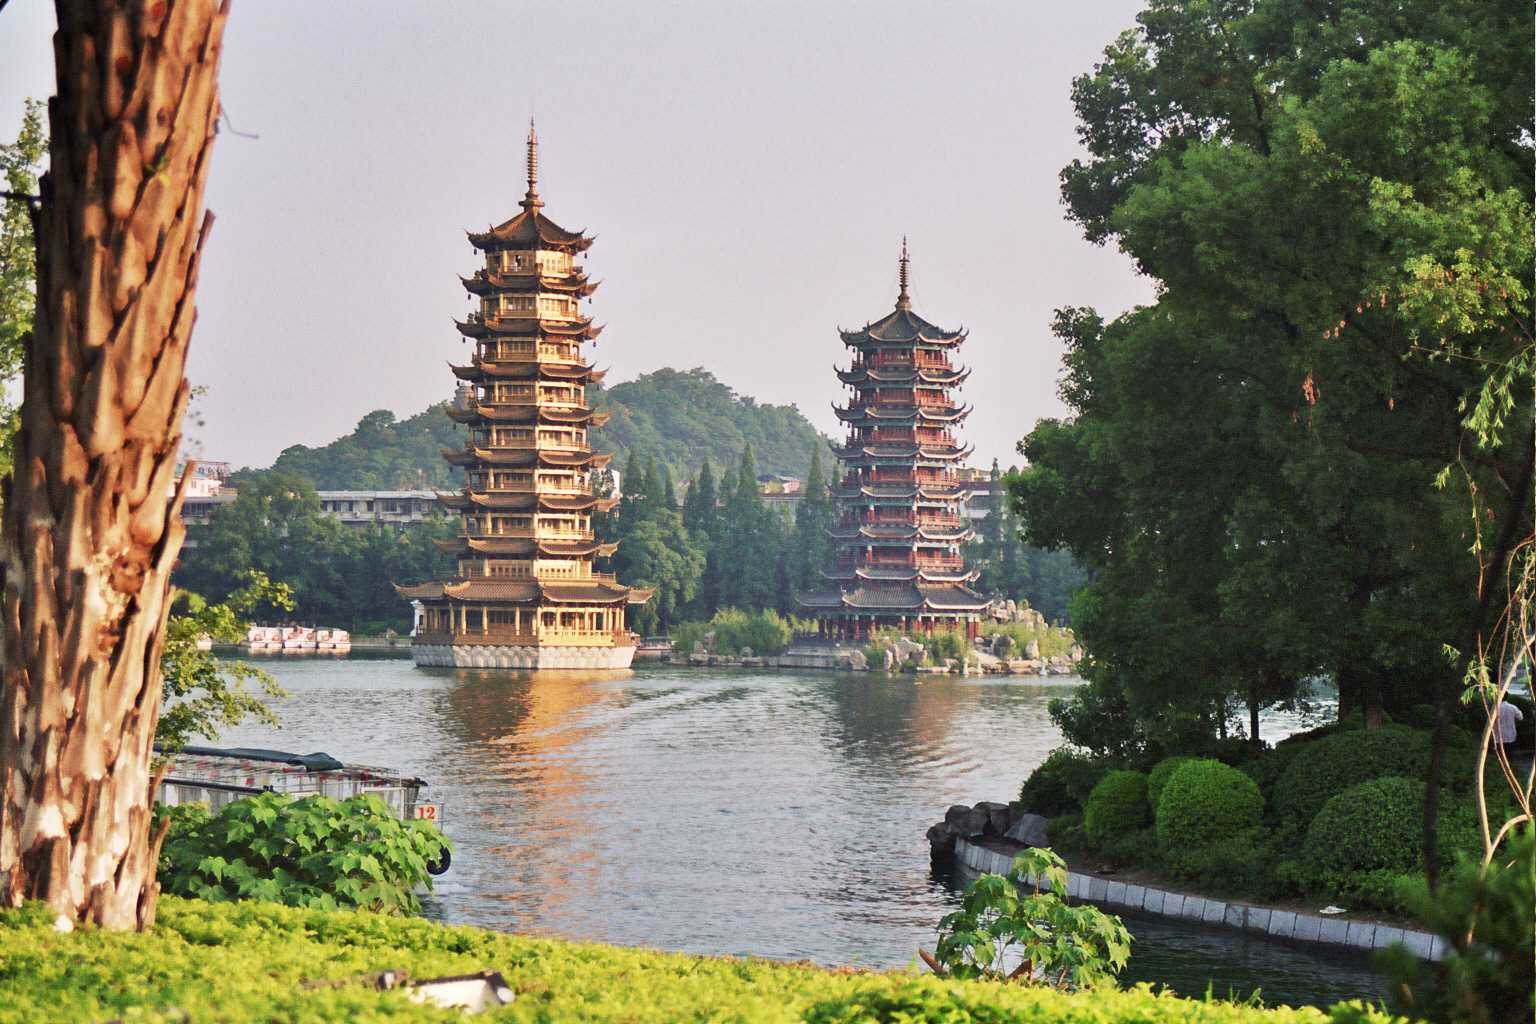

Image Size: 1536x1024 pixels


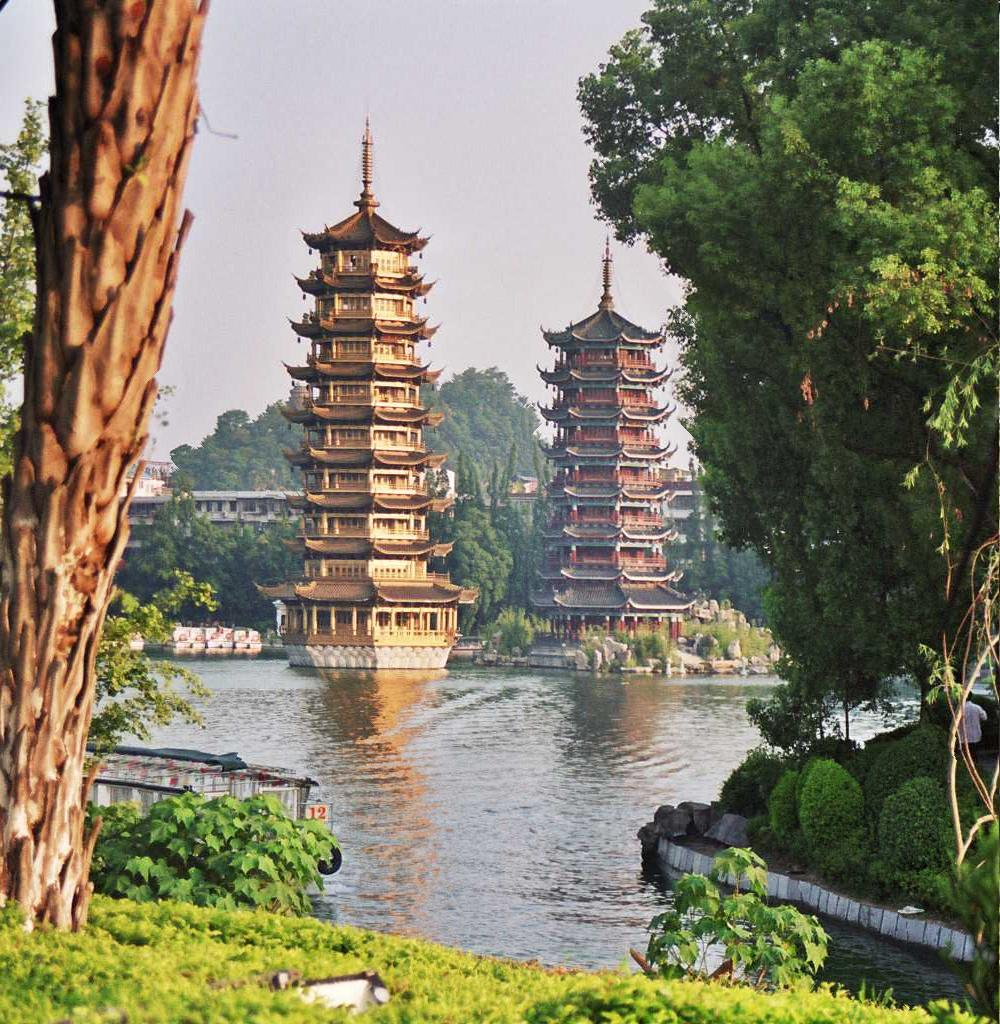

Image Size: 1000x1024 pixels


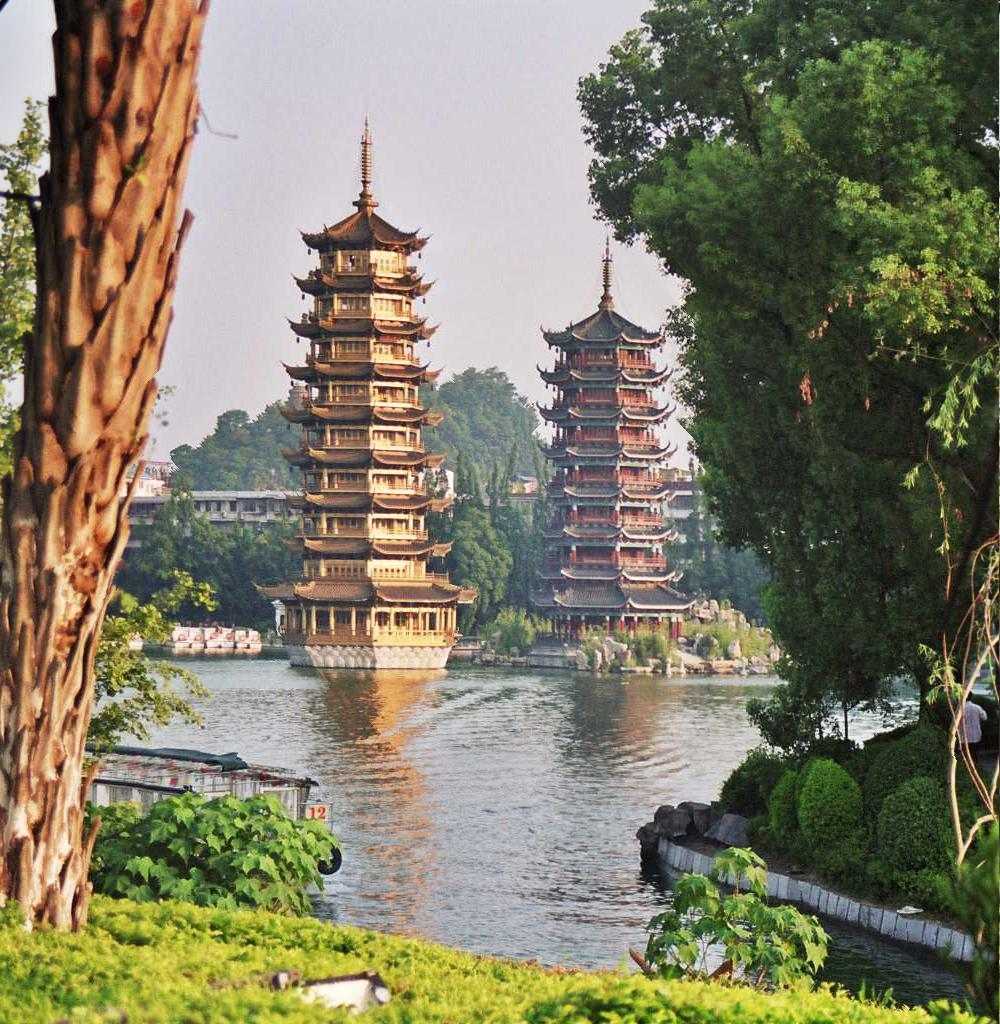

Image Size: 1000x1024 pixels


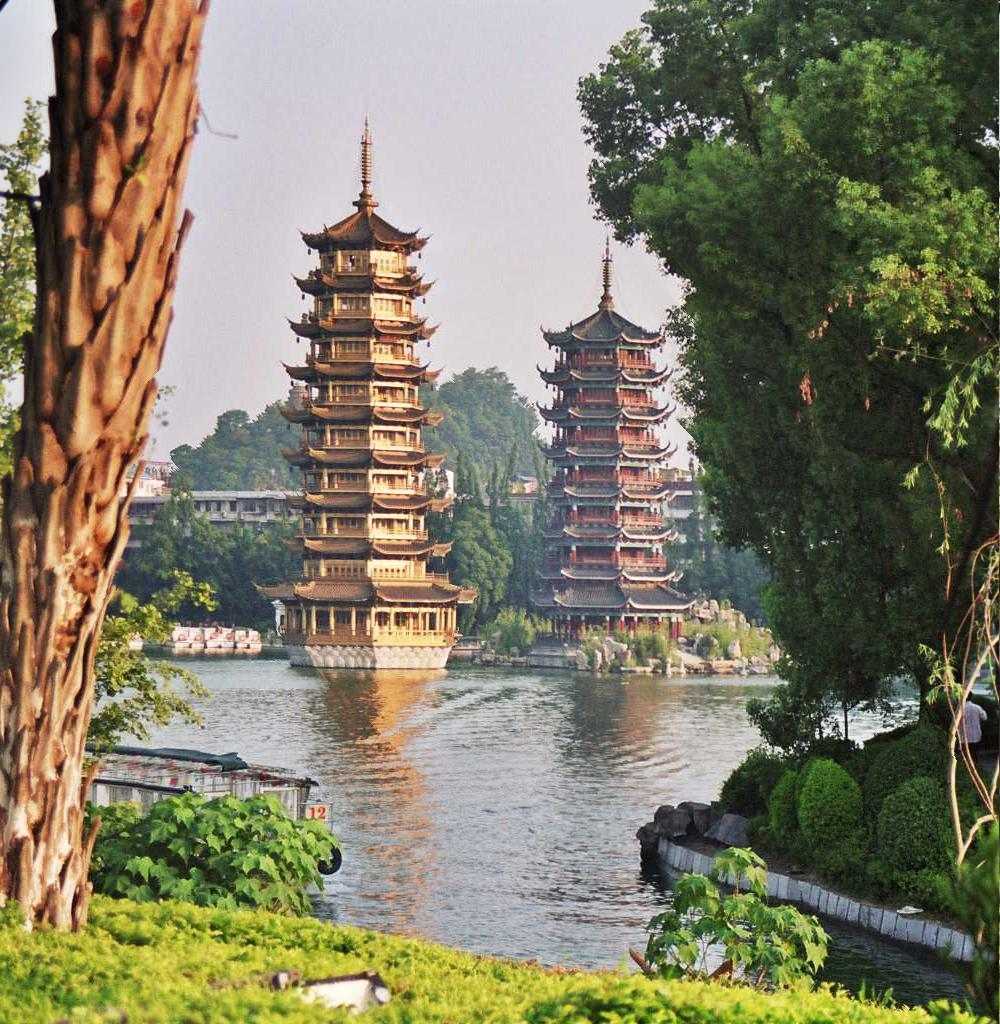

Image Size: 1000x1024 pixels


In [12]:
!./a.out -i images/pagoda.jpg -nw 1000 -bz 32
display_images("images/pagoda.jpg", "resizedImageUsingHost.jpg", "resizedImageUsingDeviceV1.jpg", "resizedImageUsingDeviceV2.jpg")

In [7]:
!./a.out -i images/pagoda.jpg -nw 1000 -bz 16

__________ GPU Device Information __________
| Name:                          Tesla T4
| Compute Capability:            7.5
| Num SMs:                       40
| Max Threads per SM:            1024
| Max Warps per SM:              32
| Global Memory (GMEM):          15835660288 bytes
| Shared Memory per SM:          65536 bytes
| Shared Memory per Block:       49152 bytes
|____________________________________________
Image size: 1536x1024
Resized image size: 1000x1024

Seam Carving by host
Time: 21016.039 ms

Seam Carving by device V1
Time: 1246.118 ms
Error Distance: 2.056

Seam Carving by device V2
Time: 1132.843 ms
Error Distance: 2.056


In [8]:
!./a.out -i images/pagoda.jpg -nw 1000 -bz 8

__________ GPU Device Information __________
| Name:                          Tesla T4
| Compute Capability:            7.5
| Num SMs:                       40
| Max Threads per SM:            1024
| Max Warps per SM:              32
| Global Memory (GMEM):          15835660288 bytes
| Shared Memory per SM:          65536 bytes
| Shared Memory per Block:       49152 bytes
|____________________________________________
Image size: 1536x1024
Resized image size: 1000x1024

Seam Carving by host
Time: 21962.576 ms

Seam Carving by device V1
Time: 1268.093 ms
Error Distance: 2.056

Seam Carving by device V2
Time: 1135.382 ms
Error Distance: 2.056


# Phân tích kết quả

In [9]:
# modify main to only run on version 2
!nvprof ./a.out -i images/pagoda.jpg -nw 1000 -bz 32

==764== NVPROF is profiling process 764, command: ./a.out -i images/pagoda.jpg -nw 1000 -bz 32
__________ GPU Device Information __________
| Name:                          Tesla T4
| Compute Capability:            7.5
| Num SMs:                       40
| Max Threads per SM:            1024
| Max Warps per SM:              32
| Global Memory (GMEM):          15835660288 bytes
| Shared Memory per SM:          65536 bytes
| Shared Memory per Block:       49152 bytes
|____________________________________________
Image size: 1536x1024
Resized image size: 1000x1024

Seam Carving by host
Time: 21882.391 ms

Seam Carving by device V1
Time: 1266.403 ms
Error Distance: 2.056

Seam Carving by device V2
Time: 1134.370 ms
Error Distance: 2.056
==764== Profiling application: ./a.out -i images/pagoda.jpg -nw 1000 -bz 32
==764== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   78.29%  1.84967s      1072  1.7254ms  983.67us  3.6359

## Bảng tóm tắt kết quả chạy

Kết quả chạy với các kích thước ảnh khác nhau:

| Kích Thước Ảnh  | Tốc Độ Host (ms) | Tốc Độ Device V1 (ms) | Tốc Độ Device V2 (ms) | Tỷ Lệ Tương Quan (Host/V1) | Tỷ Lệ Tương Quan (Host/V2) |
|-----------------|-------------------|-------------------------|-------------------------|------------------------------|------------------------------|
| 310x210         | 176.563           | 49.897                  | 49.366                  | 3.537                        | 3.579                        |
| 620x417         | 844.902           | 112.576                 | 112.058                 | 7.503                        | 7.530                        |
| 1536x1024       | 21721.801         | 1272.879                | 1124.856                | 17.056                       | 19.304                       |


Kết quả chạy với kích thước block khác nhau:

| Blocksize | Tốc Độ Device V1 (ms) | Tốc Độ Device V2 (ms) |
|-----------|-----------------------|-----------------------|
| 32x32     | 1272.879              | 1124.856              |
| 16x16     | 1246.118              | 1132.843              |
| 8x8       | 1268.093              | 1135.382              |



## Nhận xét kết quả
- Khi chạy với blocksize khác nhau, ta thấy tốc độ chạy là không quá chênh lệch vì lượng block luôn đủ để che dấu độ trễ và đạt Occupancy tối đa trên mỗi SM/core
- Với kích thước ảnh càng lớn tỉ lệ tốc độ giữa host và device càng tăng
- Version 2 có tính vượt trội hơn version 1 nhờ giảm lượng tính toán, gọi kernal, khai báo dữ liệu, ... không cần thiết
- Hàm findEnergyMapDeviceV1 chiếm phần lớn thời gian sử dụng GPU với 78.29% tổng thời gian, trong khi findSeamDeviceV1 cũng tốn nhiều thời gian với 14.35%. Việc đồng bộ GPU bằng cudaDeviceSynchronize cũng chiếm một phần lớn thời gian với 91.15% trong các cuộc gọi API.
- Mô hình hoàn thành tốt nhiệm vụ thu nhỏ kích thước ảnh mà vẫn giữ được các đối tượng trong ảnh không bị bóp méo quá nhiều so với phương pháp truyền thống





## Khó khăn trong quá trình thực hiện
- Do ít tiếp xúc với ngôn ngữ C, nhóm mất tương đối thời gian để setup các thư viện và chia cấu trúc file
- Khả năng debug của CUDA trên Colab còn hạn chế dẫn đến quá trình bắt lỗi và sữa chữa mất nhiều thời gian

# Cải tiến trong tương lai
- Thêm cơ chế giảm chiều dọc của ảnh
- Lưu lại các seam của mỗi ảnh để các chương trình khác sử dụng như một ứng dụng resize thời gian thực
- Thử nghiệm song song hoá phần tìm cột nhỏ nhất trong hàm findSeamDeviceV1
- Thử nghiệm truy cập vùng nhớ một cách liên tiếp trong hàm findEnergyMapDeviceV1

# Tài liệu tham khảo

- Shai Avidan & Ariel Shamir, Seam Carving for Content-Aware Image Resizing
- [Wikipedia - Seam Carving]("https://en.wikipedia.org/wiki/Seam_carving" "wikipedia")
-  [Seam Carving | Week 2 | 18.S191 MIT Fall 2020 | Grant Sanderson]("https://www.youtube.com/watch?v=rpB6zQNsbQU")
- [Seam Carving: Live Coding Session | Week 2 | MIT 18.S191 Fall 2020 | James Schloss]("https://www.youtube.com/watch?v=ALcohd1q3dk")   